In [34]:
%matplotlib inline
import numpy as np
import pypico
import pandas as pd
import matplotlib.pyplot as plt
import emcee
import corner

In [2]:
# Note i didn't upload the data file to github as it's too large
# comment my path and change to your own path to see data

# pico data on pypico's github
pico = pypico.load_pico("../data/jcset_py3.dat")
# FROM: http://pla.esac.esa.int/pla/aio/product-action?COSMOLOGY.FILE_ID=COM_PowerSpect_CMB-TT-full_R3.01.txt
df = pd.read_table('../data/COM_PowerSpect_CMB-TT-full_R3.01.txt', skiprows=1, names=['l', 'Dl', '-dDl', '+dDl'], delimiter='  ')

/var/folders/_2/d0xmq0nn39z8s3ccvbbr049h0000gn/T/ipykernel_30629/2570485871.py:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_table('../data/COM_PowerSpect_CMB-TT-full_R3.01.txt', skiprows=1, names=['l', 'Dl', '-dDl', '+dDl'], delimiter='  ')


In [3]:
# example parameters from pypico
As = 2.08e-9
ns = 0.97
tau = 0.055
ombh2 = 0.0225
omch2 = 0.117
H0 = 50
omk = -0.05
pivot_scalar = 0.05


In [4]:
df

l           Dl        -dDl         +dDl
0        2.0   225.895000  132.369000   533.062000
1        3.0   936.920000  450.471000  1212.308000
2        4.0   692.238000  294.111000   666.469000
3        5.0  1501.705000  574.432000  1155.804000
4        6.0   557.611000  201.242000   375.763000
...      ...          ...         ...          ...
2502  2504.0   212.915616  110.537143   110.537143
2503  2505.0    54.752355  110.824874   110.824874
2504  2506.0  -149.315007  111.110198   111.110198
2505  2507.0   -71.474213  111.427400   111.427400
2506  2508.0    51.632731  111.716422   111.716422

[2507 rows x 4 columns]

note that
\begin{equation}
D_l = C_{l}\frac{l(l + 1)}{2\pi}
\end{equation}

In [5]:
pico.outputs()

['cl_TT']

In [6]:
# to generate data for power spectrum
def model(As, ns, tau, ombh2, omch2, H0, omk, pico=pico):
    #load our input dire
    input_dir = {'As': As,
                'ns': ns,
                'tau': tau,
                'ombh2': ombh2,
                'omch2': omch2,
                'H0': H0,
                'omk': omk}

    result = pico.get(**input_dir, force=True)      # set True as we will use MCMC
    dl_TT = result['dl_TT']

    # TODO: the pico.outputs() gives ['cl_TT']; the result above gives ['dl_TT']
    # do i have to transfer as above?
    #cl_TT = [dl_TT[i]*2*np.pi/(i*(i+1)) for i in range(len(dl_TT))]

    return dl_TT


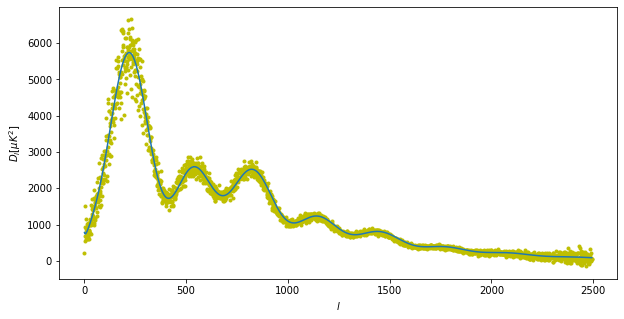

In [7]:
# just plot the example data to make sure we are on the right track
dl = model(As, ns, tau, ombh2, omch2, H0, omk)
dl = dl[2:]

plt.figure(figsize=(10, 5))
#plt.errorbar(df['l'][:len(dl)], df['Dl'][:len(dl)], yerr=df['+dDl'][:len(dl)], fmt=".y", capsize=0)
plt.scatter(df['l'][:len(dl)], df['Dl'][:len(dl)], c='y', marker='.')
plt.plot(df['l'][:len(dl)], dl)
plt.xlabel("$l$")
plt.ylabel("$D_{l} [\mu K^2]$")
plt.show()

In [17]:
# helper function for MCMC

def log_prior(theta):
    As, ns, tau, ombh2, omch2, H0, omk = theta

    if (1e-10 < As < 9e-9 and .3 < ns < 1.5 and -.4 < tau < .6 and 0 < ombh2 < .1 and -.1 < omch2 < .6 and 0 < H0 < 120 and -0.15 < omk < 0.1):
        return 0
    return -np.inf


def log_likeli(theta, df=df):
    #load data
    As, ns, tau, ombh2, omch2, H0, omk = theta
    dmodel = model(As, ns, tau, ombh2, omch2, H0, omk)
    data = df.copy()
    # keep l of model and data the same
    dmodel = dmodel[2:]
    data = data[:len(dmodel)]

    data['err'] = (data['+dDl'] + data['-dDl']) / 2
    data['err2'] = data['err']**2

    return -0.5 * np.sum(((data['Dl'] - dmodel)/data['err2']) ** 2  + np.log(data['err2'])*2*np.pi)


def log_post(theta, df=df):
    data = df.copy()
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likeli(theta, df=df)

In [18]:
# set MCMC
nwalkers = 30
ndim = 7

num_iter = 5000

pos = 0.01*np.random.rand(nwalkers, ndim)+.995
pos[:, 0] *= As
pos[:, 1] *= ns
pos[:, 2] *= tau
pos[:, 3] *= ombh2
pos[:, 4] *= omch2
pos[:, 5] *= H0
pos[:, 6] *= omk

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_post)
sampler.run_mcmc(pos, num_iter, progress=True)

100%|██████████| 5000/5000 [05:28<00:00, 15.24it/s]


State([[ 2.14847544e-09  8.93267039e-01  4.12937064e-03  3.23221128e-02
   1.37859266e-01  6.84946024e+01 -2.96553472e-02]
 [ 2.07634966e-09  6.79839086e-01 -1.14619159e-01  2.72002467e-02
   2.07172399e-01  4.66347923e+01 -6.16584216e-02]
 [ 2.58672794e-09  1.00471191e+00  1.73543852e-01  1.60492220e-02
   1.15960622e-01  3.42246301e+01 -1.72908929e-01]
 [ 3.64504057e-09  7.99120365e-01  4.27800923e-01  2.89879337e-02
   1.21221623e-01  6.88151112e+01 -2.17072088e-02]
 [ 1.92529265e-09  7.79025489e-01  8.35968520e-02  2.74798491e-02
   1.25392987e-01  9.74995299e+01  3.92789954e-02]
 [ 4.05379153e-09  1.03371652e+00  4.39688696e-01  2.14917099e-02
   1.37261407e-01  6.28309360e+01  2.68090381e-02]
 [ 2.32663302e-09  1.04470283e+00  1.51423372e-01  3.38371170e-02
   9.35382979e-02  5.20096445e+01 -1.04390547e-01]
 [ 1.99356760e-09  9.72257809e-01  9.32699723e-02  2.29456212e-02
   1.61037604e-01  3.45156406e+01 -1.55955857e-01]
 [ 2.10871323e-09  1.10587459e+00  1.47393601e-01  1.82532

In [19]:
samples = sampler.get_chain()
flat_samples = sampler.get_chain(discard=1000, thin=15, flat=True)

In [38]:
err_bar = np.std(flat_samples, axis=0)
err_bar

array([8.85210979e-10, 1.48786796e-01, 2.07373085e-01, 5.92133058e-03,
       6.98121683e-02, 2.23211887e+01, 7.72068319e-02])

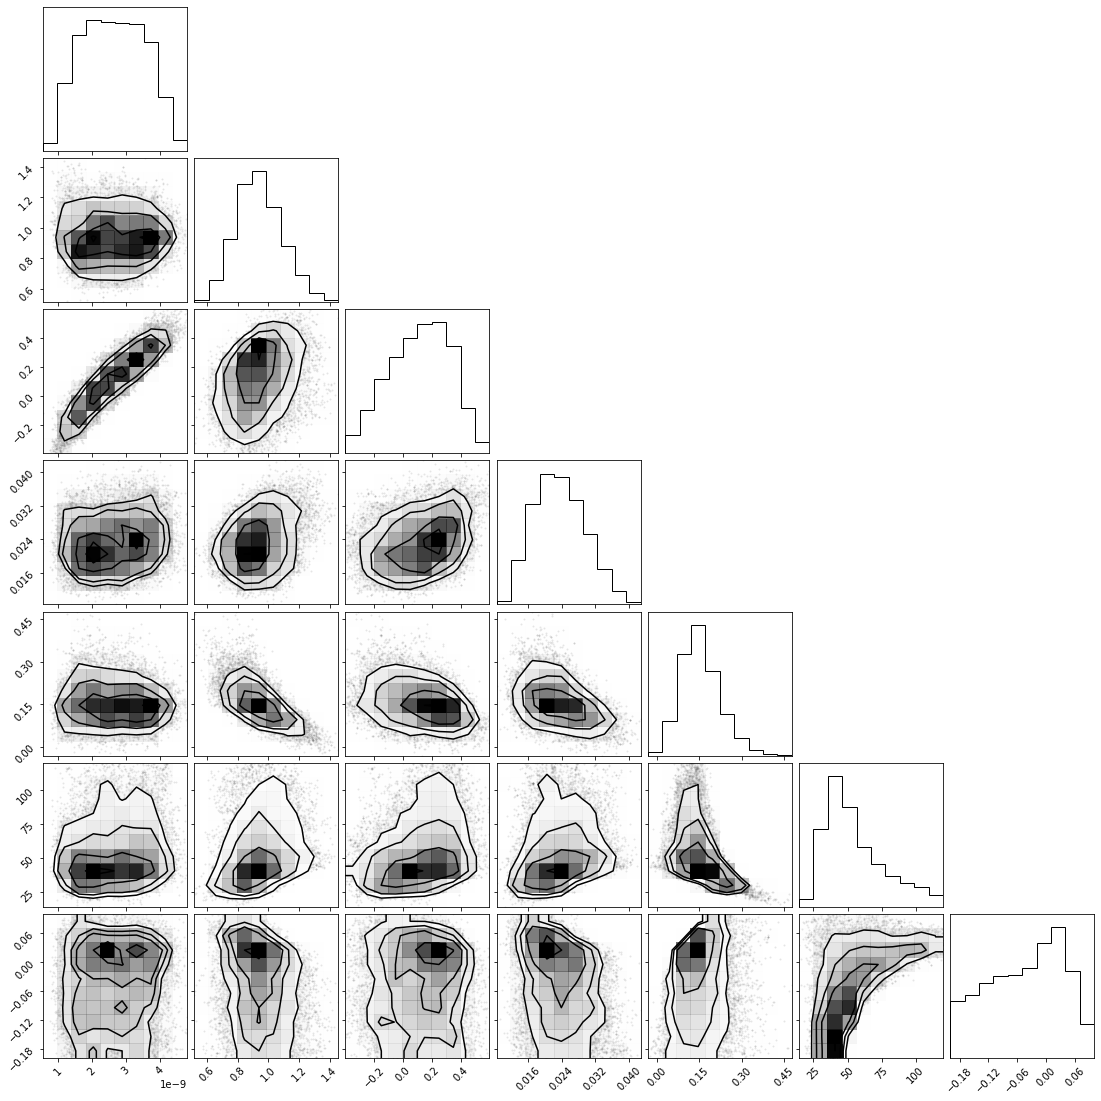

In [21]:
fig = corner.corner(flat_samples, bins=10)
# var_names=['As', 'ns', 'tau', 'ombh2', 'omch2', 'H0', 'omk']

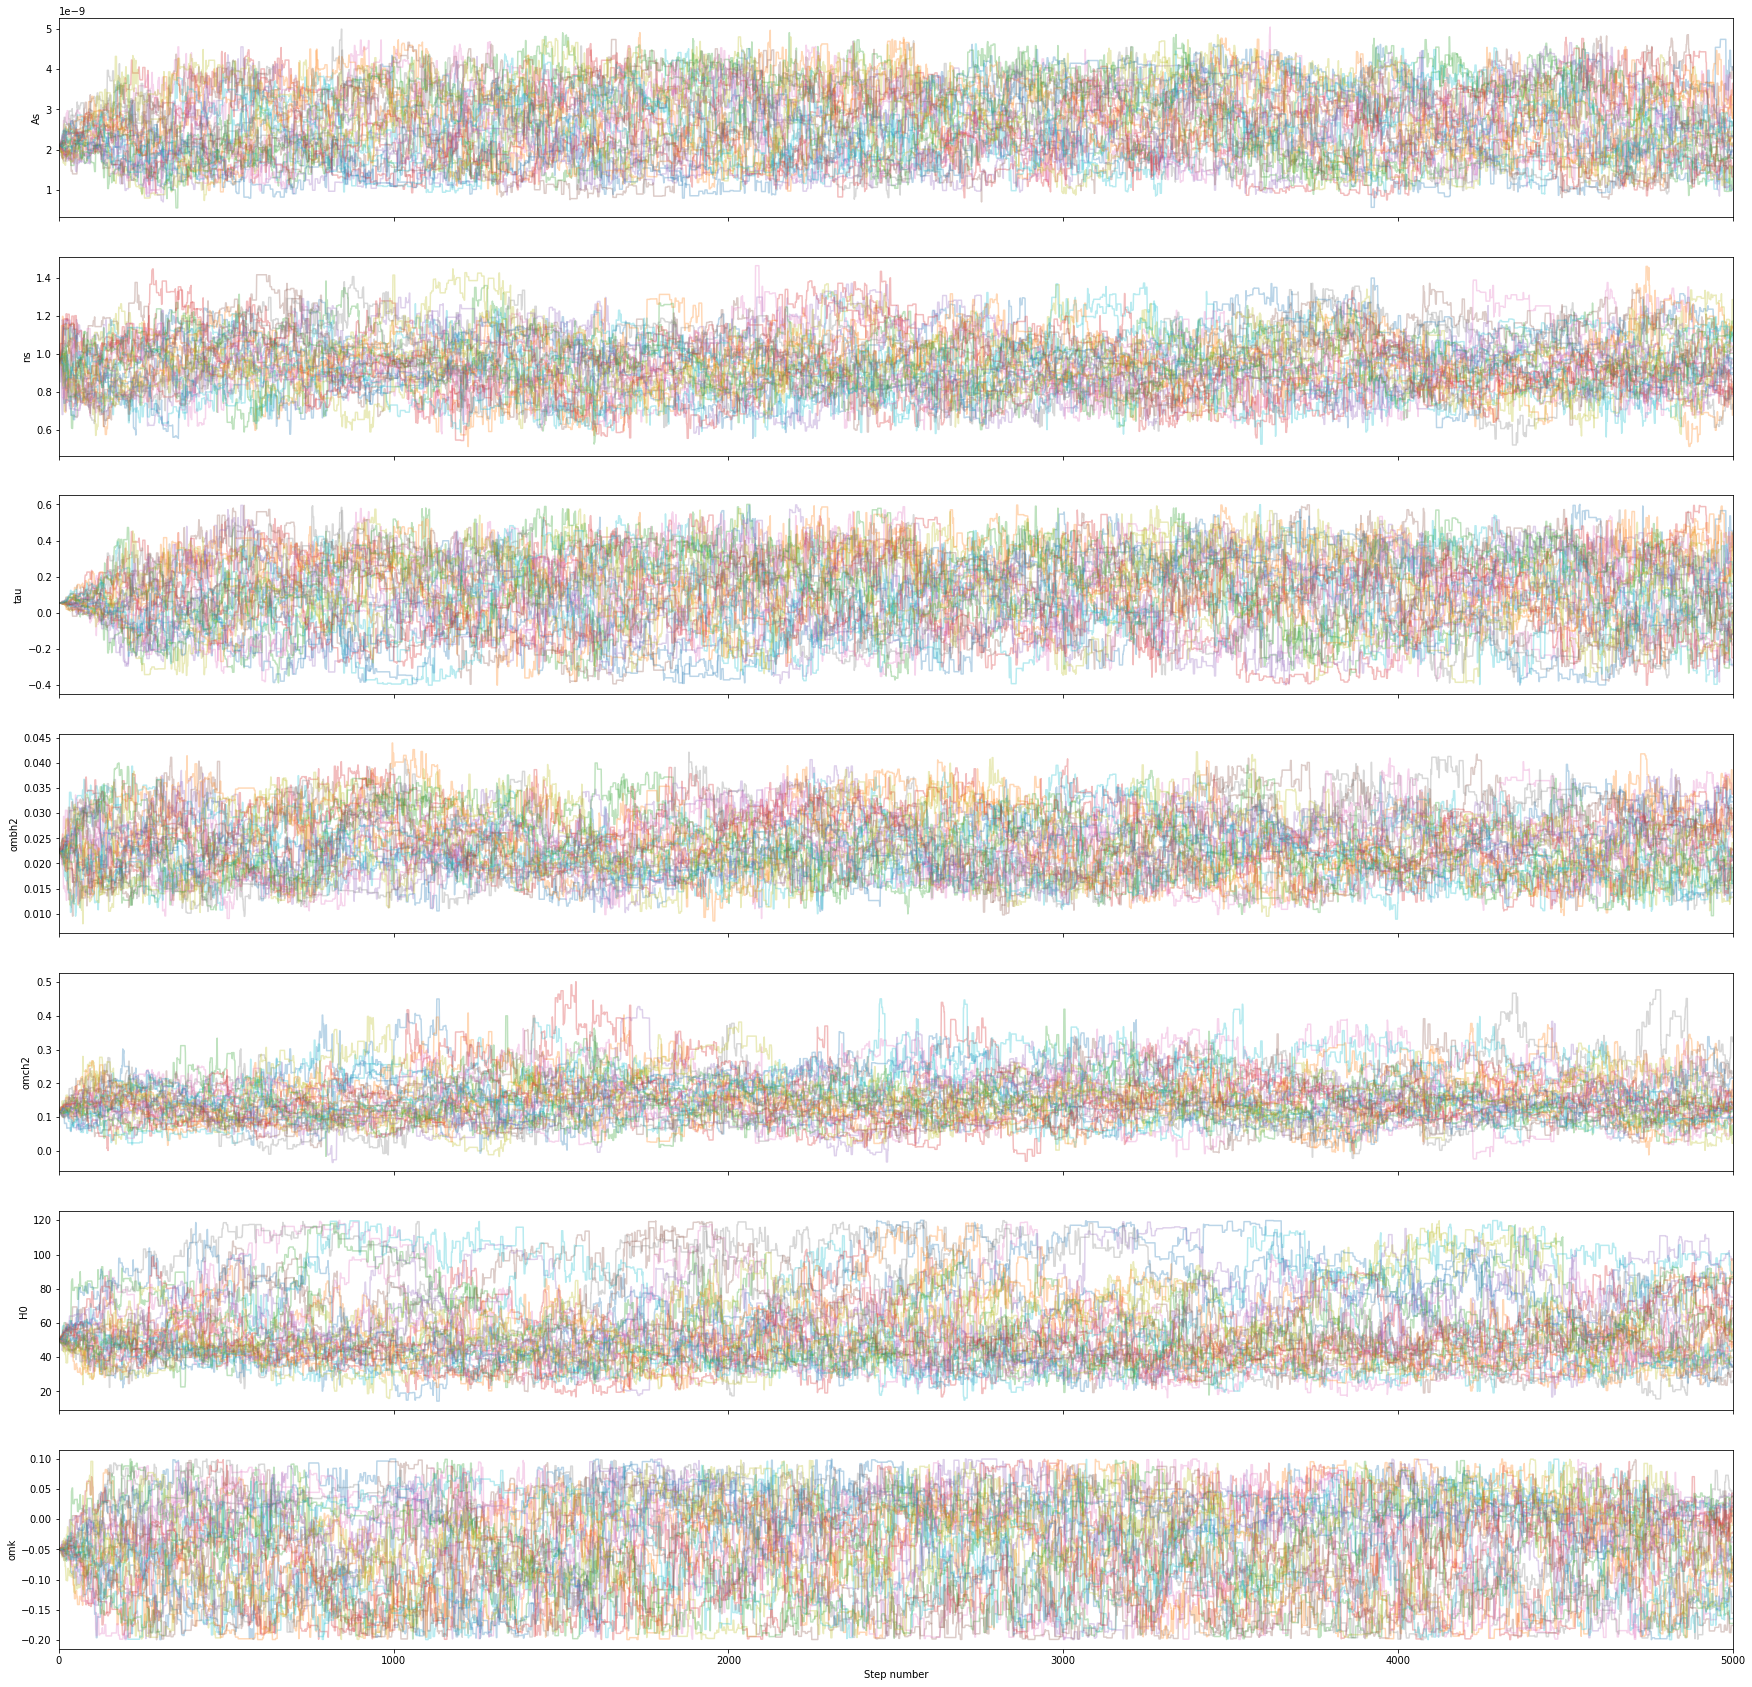

In [22]:
f, axes = plt.subplots(ndim, figsize=(30, 30), sharex=True)
samples = sampler.get_chain()
labels = ['As', 'ns', 'tau', 'ombh2', 'omch2', 'H0', 'omk']
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    #ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("Step number");

Text(0, 0.5, '$D_{l} [\\mu K^2]$')

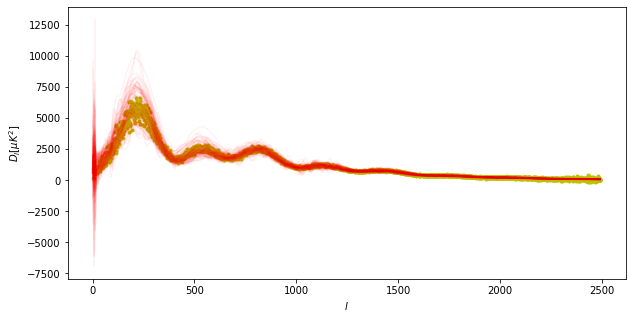

In [25]:
inds = np.random.randint(len(flat_samples), size=100)
x = df['l'][:len(dl)]

plt.figure(figsize=(10, 5))
for ind in inds:
    s = flat_samples[ind]
    As_s, ns_s, tau_s, ombh2_s, omch2_s, H0_s, omk_s = s
    dl_s = model(As_s, ns_s, tau_s, ombh2_s, omch2_s, H0_s, omk_s)[2:]
    plt.plot(x, dl_s, alpha=0.05, color='red')
#plt.errorbar(df['l'][:len(dl)], df['Dl'][:len(dl)], yerr=df['+dDl'][:len(dl)], fmt=".y", capsize=0)
plt.scatter(df['l'][:len(dl)], df['Dl'][:len(dl)], c='y', marker='.')
plt.xlabel("$l$")
plt.ylabel("$D_{l} [\mu K^2]$")

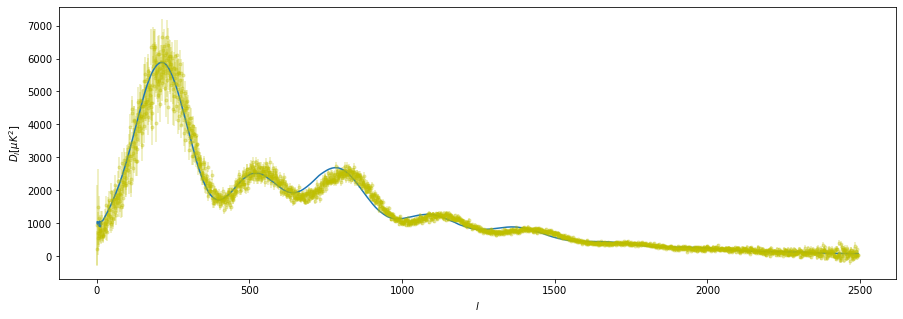

In [29]:
mean_param = np.mean(np.mean(samples, axis=0), axis=0)
# mean_param = np.mean(flat_samples, axis=0)

As_m, ns_m, tau_m, ombh2_m, omch2_m, H0_m, omk_m = mean_param
dl = model(As_m, ns_m, tau_m, ombh2_m, omch2_m, H0_m, omk_m)
dl = dl[2:]

plt.figure(figsize=(15, 5))
plt.errorbar(df['l'][:len(dl)], df['Dl'][:len(dl)], yerr=df['+dDl'][:len(dl)], fmt=".y", capsize=0, alpha=0.3)
#plt.scatter(df['l'][:len(dl)], df['Dl'][:len(dl)], c='y', marker='.')
plt.plot(df['l'][:len(dl)], dl)
plt.xlabel("$l$")
plt.ylabel("$D_{l} [\mu K^2]$")
plt.show()

In [30]:
mean_param

array([ 2.61059519e-09,  9.44550670e-01,  1.09533137e-01,  2.35848797e-02,
        1.51579786e-01,  5.56014337e+01, -4.60545992e-02])